In [1]:
%display latex

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [2, 2]

In [2]:
N = 3
d = 2^N
F = GF(d, 'x')
x = F.gen()

In [3]:
x.charpoly()

x^3 + x + 1

In [4]:
def Proj(u, v=None):
    if not v:
        v = u
    return u * v.conjugate_transpose()

Id = identity_matrix(SR, 2^N)

def toInt(k):
    return list(F).index(k)

def chi(k):
    return exp(2 * pi * I * int(k.trace()) / 2)

In [5]:
def Fourier():
    s = zero_matrix(SR, 2^N, 2^N)
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            s[i,j] = chi(a * b) / sqrt(2^N)
    return s
FF = Fourier()

def Z(a):
    return diagonal_matrix([chi(a * k) for k in F])

def X(b):
    return FF.conjugate_transpose() * Z(b) * FF

The construction of the rotation operators supposedly proceeds in the same manner as for the straight lines. But instead of having curves given by $\beta = \xi \alpha$ we have curves given by a parametrized function $f_\mu$ that satisfies some, until now, unkown conditions. The rotation parameters are again diagonal in the conjugate basis:
$$
V_{f_\mu}
= \sum_{\kappa} c_{f_\mu,\alpha} |\tilde\kappa\rangle \langle\tilde\kappa|,
$$
and
$$
V_{f_\mu} Z_\alpha V_{f_\mu}^* = c_{f_\mu,\alpha} Z_\alpha X_{f_\mu(\alpha)}.
$$
This leads once more to a recurrence relation supposedly of the form:
$$
c_{\alpha+\kappa,f_\mu} c_{\kappa,f_\mu}^*
= c_{\alpha,f_\mu} \chi[-\kappa f_\mu(\alpha)]
= c_{\alpha,f_\mu} \chi[\kappa f_\mu(\alpha)].
$$

For now we want to replicate Muñoz's phase using the Galois ring method that Sainz uses, i.e., we will try to get the rotation operators $V_\xi$ in the case of straight lines.

So the method consists first of lifting the group character of the field to the Galois ring. In this case we are are interested in the Galois ring $GR(4,N)$ where $N$ is the number qubits.

In [6]:
R = PolynomialRing(Integers(4), 't')
t = R.gen()

In [7]:
poly = t^3 + 2*t^2 + t - 1
factor(poly)

t^3 + 2*t^2 + t + 3

In [8]:
poly * (t^3 - t^2 + 2*t - 1) * (t-1)

t^7 + 3

The polynomial `poly` is irreducible in $\mathbb Z_4$ and so we can construct a Galois ring much in the same maner as the Galois field extensions, that is by taking the quotient of the generated ideal of the polynomial.

Using the specific polynomial is advantageous since the root of $t^3 + 2t^2 + t - 1$ is a $7$-th root of unity in $GR(4,3)$. The $(p^r-1)$-th primitive roots of unity can be used to express any element in the Galois ring in the so called $p$-adic representation.

In [9]:
GR = R.quotient(poly, 'w')
w = GR.gen()
GR

Univariate Quotient Polynomial Ring in w over Ring of integers modulo 4 with modulus t^3 + 2*t^2 + t + 3

In [10]:
GR.cardinality()

64

Using the chosen polynomial, the ring generator can be used as the Teichmüller set $\mathcal T$ generator:

In [11]:
w^(2^N-1)

1

In [12]:
T = [GR(0)] + [w**j for j in range(1, 2**N - 1)] + [GR(1)]

In [13]:
len(T)

8

In our exmaple the Teichmüller set $\mathcal T$ is isomorphic to the finite field $GF(2^3)$. The mapping from the field to $\mathcal T$ is called the *Teichmüller lift*, denoted by $\alpha \mapsto \hat{\alpha}$. As the structure is multiplicative, we assume that the lift is done by matching powers of the generating elements. The generator of the finite field $x$ is mapped to $w$ and so follow the powers.

In [14]:
T

[0, w, w^2, 2*w^2 + 3*w + 1, 3*w^2 + 3*w + 2, w^2 + 3*w + 3, w^2 + 2*w + 1, 1]

In [15]:
list(F)

[0, x, x^2, x + 1, x^2 + x, x^2 + x + 1, x^2 + 1, 1]

In [16]:
def TeichLift(k):
    return T[toInt(k)]

Let's quickly verify that the map is indeed a multiplicative group homomorphism.

In [17]:
for k in F:
    for l in F:
        if TeichLift(k * l) != TeichLift(k) * TeichLift(l):
            raise Exception('Not a homomorphism!')

It is easy to verify that addition does not map trivially:

In [18]:
TeichLift(x + 1) == TeichLift(x) + TeichLift(1)

False

To appropriately map addition we must add another term given by the square root of the added numbers, $$\widehat{a + b} = \hat a + \hat b  + 2 \sqrt{\hat a \hat b}.$$ Unfortunately `SageMath` does not implement the square root function for the algebraic structure in question. But we can brute force it:

In [19]:
def TSquareRoot(k):
    for l in T:
        if l^2 == k:
            return l

In [20]:
for a in F:
    for b in F:
        if TeichLift(a + b) != TeichLift(a) + TeichLift(b) + GR(2) * TSquareRoot(TeichLift(a * b)):
            raise Exception('The addition rule failed!')

For this first example we consider the function $f_\mu(\alpha) = \mu \alpha$. And so according to Sainz the phase that solves the rotation coefficients recurrence equation is given by:
$$
\phi(\alpha, f_\mu(\alpha))
= c_{\alpha,f_\mu}
= (i)^{Tr(\hat \alpha f_{\hat\mu}(\hat \alpha))}
= (i)^{Tr(\hat\mu\hat\alpha^2)},
$$
where the trace function leaves the ring $\mathbb Z_4$ invariant. We note several differences with Muñoz's method. First the Hadamard bit counting function is probably doing the same thing as the trace function here, but in Muñoz's coefficient the square root of the product is used, as well as the root $-i$. This produces  MUBs that appear distinct, but are probably related by permutations and global phases.

In [21]:
def RingTrace(a, b):
    s = GR(0)
    for k in range(N):
        s += a**(2**k) + GR(2)*b**(2**k)
    return s 

# to evaluate the trace in the ring we need
# to use the p-adic representation of the elements
# of the Teichmüller.
def Dumb2adic(x):
    for b in T:
        # a = x - GR(2)*b
        # if a in T:
        #     return (a,b)
        for a in T:
            if x == (a + GR(2) * b):
                return (a,b)

In [22]:
for k in T:
    if k.trace() != RingTrace(*Dumb2adic(k)):
        raise Exception('Difference in trace implementation.')

Oops, just realized SageMath took care of the trace function!

In [23]:
# phase defined by the rotation coeffs
def phi(tau, nu):
    a, b = Dumb2adic(TeichLift(tau) * TeichLift(nu))
    return (I)^(int(RingTrace(a, b)))

def D(a, b):
    return phi(a, b) * Z(a) * X(b)

Now for the rotation operators $V_\mu$.

In [24]:
def V(mu):
    s = zero_matrix(SR, 2^N, 2^N)
    for i, k in enumerate(F):
        s += phi(k, mu * k) * Proj(FF[:,i])
    return s

Now let's verify that the bases created by the rotation operators are MUBs.

In [25]:
# Orthonormality
def isOrthonormal(m):
    return m.conjugate_transpose() * m == Id

# MUBs
def isMUB(m1, m2):
    m = (
        m1.conjugate_transpose() * m2
    ).apply_map(lambda t: abs(t)^2)
    return m == ones_matrix(2^N, 2^N) / (2^N)

def checkMUBs(mubs):
    if type(mubs) != list:
        mubs_list = []
        for i in range(2^N+1):
            mubs_list.append(mubs[(i*2^N):(i+1)*2^N,:])
    else:
        mubs_list = mubs
            
    for i in range(2^N+1):
        for j in range(2^N+1):
            if i == j:
                if not isOrthonormal(mubs_list[i]):
                    raise Exception(
                        'Encountered a basis that is not orthonormal!',
                        i
                    )
            else:
                if not isMUB(mubs_list[i], mubs_list[j]):
                    raise Exception(
                        'Encountered non-MUB pairs of basis!',
                        i, j
                    )
    return True

In [26]:
mubs306 = [FF] + [V(k) for k in F]
checkMUBs(mubs306)

True

In [27]:
import numpy as np

def saveMUBs(mubs, name='mubs.npy'):
    M = mubs[0]
    for m in mubs[1:]:
        M = np.concatenate((M, m))
    np.save(name, M)

In [32]:
npMUBs = [m.numpy(dtype='complex128') for m in mubs306]
saveMUBs(npMUBs, 'sainz/306.npy')

Ok, so somehow it worked.

A quick check reveals that these are not the same as Muñoz's MUBs. It's kinda of hard to brute force check the differences, they could be permutations, sign changes or actually distinct MUBs. So let's at least see if we can get a Wigner function.

In [28]:
# This monomial form is trivial for straight lines,
# which is the case we are analyzing right now.
def Delta(a, b):
    s = zero_matrix(SR, 2^N, 2^N)
    for gamma in F:
        for delta in F:
            s += chi(a * delta + b * gamma) * D(gamma, delta) / 2^N
    return s

The displacement kernel satisfies all the properties for the straight lines (deleted the code cause it's not important). Now let's build Wootters' kernel, which for straight lines is actually equivalent to the monomial form.

In [29]:
def Wigner(state, a, b, kernel):
    return (state * kernel(a, b)).trace()

def WignerMatrix(state, kernel=Delta):
    W = zero_matrix(SR, 2^N, 2^N)
    for i, a in enumerate(F):
        for j, b in enumerate(F):
            W[i, j] = real(Wigner(state, a, b, kernel)) / 2^N
    return W

In [30]:
def Wootters(a, b):
    op = Proj(mubs306[0][:, toInt(a)]) # Fourier basis
    for xi in F:
        nu = b - xi * a
        op += Proj(mubs306[toInt(xi)+1][:, toInt(nu)])
    return op - Id

In [31]:
Delta(x, x^4) == Wootters(x, x^4)

True

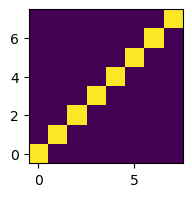

In [32]:
W = WignerMatrix(Proj(V(F(1))[:,0]), kernel=Wootters)
plt.imshow(W.transpose().apply_map(lambda t: float(t)), origin='lower')

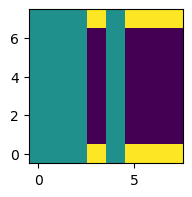

In [33]:
ghz = (Id[:,0] + Id[:,-1])/sqrt(2)
W = WignerMatrix(Proj(ghz), kernel=Wootters).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

All is well with the straight line kernel.

---
So now the idea is to use Sainz phase but for curves instead of straight lines. The curves that we will use are the ones that Andres found. They correspond to distinct factorization schemes. Here are the $(1,6,2)$ factorization curves:
$$
\begin{align*}
\alpha &= 0 \\
f_0(\alpha) &= \alpha^2 + \alpha^4 \\
f_\mu(\alpha) &= \mu \alpha + \alpha^2 + \alpha^4 \\
f_{\mu^2}(\alpha) &= \mu^2 \alpha + \alpha^2 + \alpha^4 \\
f_{\mu^3}(\alpha) &= \mu^3 \alpha + \alpha^2 + \alpha^4 \\
f_{\mu^4}(\alpha) &= \mu^4 \alpha + \alpha^2 + \alpha^4 \\
f_{\mu^5}(\alpha) &= \mu^5 \alpha + \alpha^2 + \alpha^4 \\
f_{\mu^6}(\alpha) &= \mu^6 \alpha + \alpha^2 + \alpha^4 \\
f_1(\alpha) &= \alpha + \mu \alpha^2 + \mu \alpha^4
\end{align*}
$$
Notice that the general form of the curves is $f_\mu(\alpha) = \mu \alpha + \alpha^2 + \alpha^4$ where $\mu = x^k$ for some $k$ and $x$ the field generator.

After verifying that the curves are ok, we can obtain Sainz's phase  by:
$$
\phi(\alpha, f_\mu(\alpha))
= c_{\alpha,f_\mu}
= (i)^{Tr(\hat \alpha f_{\hat\mu}(\hat \alpha))}
%= (i)^{Tr(\hat \alpha (\hat \mu \hat \alpha +  \hat x \hat \alpha^2 + \hat x \hat \alpha^4))}
%= (i)^{Tr(\hat \mu \hat \alpha^2 +  \hat x \hat \alpha^3 + \hat x \hat \alpha^5)},
$$

In [54]:
def phi2(tau, nu):
    # a, b = Dumb2adic(tau * nu)
    # return (I)^(int(RingTrace(a, b)))
    return I^(int((tau * nu).trace()))

# \mu is the function parameter and x is the generator.
# The lifting operator ^ : F -> T is a multiplicative group
# homomorphism so ^(x * k) = ^x * ^k.
# Addition must be done inside T.
def V2(mu):
    s = zero_matrix(SR, 2^N, 2^N)
    for i, k in enumerate(F):
        hk = TeichLift(k)
        s += phi2(TeichLift(k), TeichLift(mu) * hk + hk^2 + hk^4) * Proj(FF[:,i])
    return s

In [55]:
mubs162 = [FF] + [V2(k) for k in F]
checkMUBs(mubs162)

True

For starters let's see that these curves generate totally isotropic subspaces:

In [56]:
# (1,6,2)
curves = [
    lambda a: a^2 + a^4,
    lambda a: x * a + a^2 + a^4,
    lambda a: x^2 * a + a^2 + a^4,
    lambda a: x^3 * a + a^2 + a^4,
    lambda a: x^4 * a + a^2 + a^4,
    lambda a: x^5 * a + a^2 + a^4,
    lambda a: x^6 * a + a^2 + a^4,
    lambda a: a + a^2 + a^4
]

for j, curve in enumerate(curves):
    subspace = [(a, curve(a)) for a in F]
    # The curves are subspaces
    for p1 in subspace:
        for p2 in subspace:
            if (p1[0] + p2[0], p1[1] + p2[1]) not in subspace:
                raise Exception('Curve is not a subspace.', j)
    
    # The curves are not abelian
    for p1 in subspace:
        for p2 in subspace:
            c = p1[0] * p2[1] - p1[1] * p2[0]
            if c.trace() != 0:
                raise Exception('Not isotropic!', j)

$V_\mu$ corresponds to the curve $\beta = f_\mu(\alpha) = \mu \alpha + \alpha^2 + \alpha^4$. And so the operators of the form $D(\alpha, \mu \alpha + \alpha^2 + \alpha^4)$ for all $\alpha \in GF(2^3)$ should commute and should leave $V_\mu$ invariant.

In [57]:
def D2(a, b):
    return phi2(TeichLift(a), TeichLift(b)) * Z(a) * X(b)

In [39]:
for mu in F:
    c = lambda a: mu * a + a^2 + a^4
    for a in F:
        for l in F:
            if D2(a, c(a)) * D2(l, c(l)) != D2(l, c(l)) * D2(a, c(a)):
                raise Exception('Non-commuting operators in same curve!', a, l)

So all of the displacement operators on a given curve commute as they should.

The second MUB corresponds to the first curve where $\mu = 0$, so all of the displacement operators of the form $D(\alpha, \alpha^2 + \alpha^4)$ should leave the vectors invariant (modulo $\pm 1$ phases):

In [58]:
mubs162[1]

[   0    0    0  1/2    0  1/2  1/2 -1/2]
[   0    0    0 -1/2    0  1/2  1/2  1/2]
[   0    0    0  1/2    0  1/2 -1/2  1/2]
[ 1/2 -1/2  1/2    0  1/2    0    0    0]
[   0    0    0  1/2    0 -1/2  1/2  1/2]
[ 1/2  1/2  1/2    0 -1/2    0    0    0]
[ 1/2  1/2 -1/2    0  1/2    0    0    0]
[-1/2  1/2  1/2    0  1/2    0    0    0]

In [59]:
D2(x^2, curves[0](x^2)) * mubs162[1]

[   0    0    0 -1/2    0 -1/2  1/2 -1/2]
[   0    0    0  1/2    0 -1/2  1/2  1/2]
[   0    0    0 -1/2    0 -1/2 -1/2  1/2]
[ 1/2  1/2  1/2    0 -1/2    0    0    0]
[   0    0    0 -1/2    0  1/2  1/2  1/2]
[ 1/2 -1/2  1/2    0  1/2    0    0    0]
[ 1/2 -1/2 -1/2    0 -1/2    0    0    0]
[-1/2 -1/2  1/2    0 -1/2    0    0    0]

We can define the Wigner kernel by identifying the lines that are incident to a given point in phase-space.

In [68]:
def Wootters2(a, b):
    op = Proj(mubs162[0][:, toInt(a)]) # Fourier
    for xi in F:
        nu = b - (xi * a + a^2 + a^4)
        op += Proj(mubs162[toInt(xi) + 1][:, toInt(nu)])
    return op - Id

In [69]:
# The Wootters kernel is normalized
op = zero_matrix(SR, 2^N, 2^N)
for a in F:
    for b in F:
        op += Wootters2(a, b)
op / 8

[1 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 1]

In [70]:
# hermitian
for a in F:
    for b in F:
        if Wootters2(a, b) != Wootters2(a, b).conjugate_transpose():
            raise Exception('Not Hermitian!')

In [71]:
# Hilbert-Schmidt orthogonality
(Wootters2(x^5 + 1, x + 1) * Wootters2(x, x + 1).conjugate_transpose()).trace() / 2^N

0

In [72]:
# Covariance
alpha = x^3
beta  = x
for a in F:
    for b in F:
        if D2(a, b) * Wootters2(alpha, beta) * D2(a, b).conjugate_transpose() != Wootters2(alpha + a, beta + b):
            raise Exception('Not translationally covariant for ({}, {})!'.format(alpha, beta))

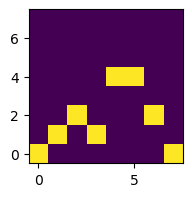

In [73]:
W = WignerMatrix(Proj(mubs162[1][:,0]), kernel=Wootters2)
plt.imshow(W.transpose().apply_map(lambda t: float(t)), origin='lower')

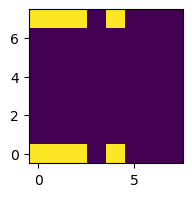

In [74]:
ghz = (Id[:,0] + Id[:,-1])/sqrt(2)
W = WignerMatrix(Proj(ghz), kernel=Wootters2)
plt.imshow(W.transpose().apply_map(lambda t: float(t)), origin='lower')

Now we try with the $(2,3,4)$ curves:
$$
\begin{align*}
\alpha &= 0 \\
\beta &= 0 \\
f(\alpha) &= x^6 \alpha + x^3 \alpha^2 + x^5 \alpha^4 \\
f(\alpha) &= x^2 \alpha + x^5 \alpha^2 + x^6 \alpha^4 \\
f(\alpha) &= x^4 \alpha + x^3 \alpha^2 + x^5 \alpha^4 \\
f(\alpha) &= x^3 \alpha \\
f(\alpha) &= x^5 \alpha + x^5 \alpha^2 + x^6 \alpha^4 \\
f(\alpha) &= x \alpha +  x^2 \alpha^2 + x \alpha^4 \\
f(\alpha) &= \alpha + x^2 \alpha^2 + x \alpha^4
\end{align*}
$$

I can't see a simple way of parametrizing these curves with one parameter, and so the parameter $\mu$ will simply pick out a curve given some order.

In [77]:
# (2,3,4)
curves = [
    lambda a: 0,
    lambda a: x^6 * a + x^3 * a^2 + x^5 * a^4,
    lambda a: x^2 * a + x^5 * a^2 + x^6 * a^4,
    lambda a: x^4 * a + x^3 * a^2 + x^5 * a^4,
    lambda a: x^3 * a,
    lambda a: x^5 * a + x^5 * a^2 + x^6 * a^4,
    lambda a: x * a + x^2 * a^2 + x * a^4,
    lambda a: a + x^2 * a^2 + x * a^4
]

# We have to lift the curves to the Teichmüller set, 
# thankfully ^x = w
curves_T = [
    lambda a: 0,
    lambda a: w^6 * a + w^3 * a^2 + w^5 * a^4,
    lambda a: w^2 * a + w^5 * a^2 + w^6 * a^4,
    lambda a: w^4 * a + w^3 * a^2 + w^5 * a^4,
    lambda a: w^3 * a,
    lambda a: w^5 * a + w^5 * a^2 + w^6 * a^4,
    lambda a: w * a + w^2 * a^2 + w * a^4,
    lambda a: a + w^2 * a^2 + w * a^4
]

# \mu is the function parameter and x is the generator.
# The lifting operator ^ : F -> T is a multiplicative group
# homomorphism so ^(x * k) = ^x * ^k.
# Addition must be done inside T.
def V3(mu):
    s = zero_matrix(SR, 2^N, 2^N)
    curve = curves_T[toInt(mu)]
    # curve = lambda k: TeichLift(mu * k) + TeichLift(x * k^2) + TeichLift(x * k^4) # 162
    # curve = lambda k: TeichLift(mu * k) # straight lines
    for i, k in enumerate(F):
        a = TeichLift(k)
        s += phi2(a, curve(a)) * Proj(FF[:,i])
    return s

In [78]:
mubs234 = [FF] + [V2(k) for k in F]
checkMUBs(mubs234)

True

So once again we have MUBs. Let's just make sure that the basis are actually eigenvectors of the corresponding displacement operators and other sanity checks.

In [79]:
mubs234[2] * 4

[-I + 1 -I + 1  I + 1  I - 1  I + 1  I + 1 -I - 1 -I + 1]
[-I + 1 -I + 1  I + 1 -I + 1  I + 1 -I - 1  I + 1  I - 1]
[ I + 1  I + 1 -I + 1  I + 1 -I + 1  I - 1 -I + 1 -I - 1]
[ I - 1 -I + 1  I + 1 -I + 1 -I - 1  I + 1  I + 1 -I + 1]
[ I + 1  I + 1 -I + 1 -I - 1 -I + 1 -I + 1  I - 1  I + 1]
[ I + 1 -I - 1  I - 1  I + 1 -I + 1 -I + 1 -I + 1  I + 1]
[-I - 1  I + 1 -I + 1  I + 1  I - 1 -I + 1 -I + 1  I + 1]
[-I + 1  I - 1 -I - 1 -I + 1  I + 1  I + 1  I + 1 -I + 1]

In [80]:
andres_mubs2 = FF * diagonal_matrix([1,-1,I,I,I,1,1,-I]) * FF.conjugate_transpose()
andres_mubs2[:,2] == mubs234[2][:,0]

False

A quick check reveals that these are actually the same MUBs as the ones Andres obtained except for permutations!

Now let's create Wootters' Wigner kernel for these curves and test its properties.

In [100]:
curves = [
    lambda a: 0,
    lambda a: x^6 * a + x^3 * a^2 + x^5 * a^4,
    lambda a: x^2 * a + x^5 * a^2 + x^6 * a^4,
    lambda a: x^4 * a + x^3 * a^2 + x^5 * a^4,
    lambda a: x^3 * a,
    lambda a: x^5 * a + x^5 * a^2 + x^6 * a^4,
    lambda a: x * a + x^2 * a^2 + x * a^4,
    lambda a: a + x^2 * a^2 + x * a^4
]

def Wootters3(a, b):
    op = Proj(FF[:, toInt(a)])
    for xi in F:
        for nu in F:
            d = int(b == (curves[toInt(xi)](a) + nu))
            v = mubs234[toInt(xi)+1][:, toInt(nu)]
            op += d * Proj(v)
    return op - Id

In [101]:
# The Wootters kernel is normalized
op = zero_matrix(SR, 2^N, 2^N)
for a in F:
    for b in F:
        op += Wootters3(a, b)
op / 8

[1 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 0 0]
[0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 1]

In [102]:
# hermitian
for a in F:
    for b in F:
        if Wootters3(a, b) != Wootters3(a, b).conjugate_transpose():
            raise Exception('Not Hermitian!')

In [103]:
# Hilbert-Schmidt orthogonality
(Wootters3(x^5 + 1, x + 1) * Wootters3(x, x + 1).conjugate_transpose()).trace() / 2^N

0

In [104]:
# Covariance
alpha = x^3
beta  = 0
for a in F:
    for b in F:
        if D2(a, b) * Wootters3(alpha, beta) * D2(a, b).conjugate_transpose() != Wootters3(alpha + a, beta + b):
            raise Exception('Not translationally covariant for ({}, {})!'.format(alpha, beta))

Exception: Not translationally covariant for (x + 1, 0)!

In [105]:
ghz = (Id[:,0] + Id[:,-1])/sqrt(2)
W = WignerMatrix(Proj(ghz), kernel=Wootters3).apply_map(lambda t: float(t))

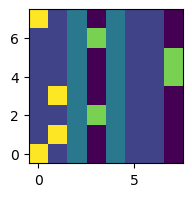

In [106]:
plt.imshow(W.transpose(), origin='lower')

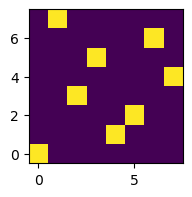

In [108]:
W = WignerMatrix(Proj(mubs234[3][:,0]), kernel=Wootters3).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

Now for the moment of truth, the test of *universality*. We must locate an eigenvector of one set of MUBs that is *not* in the other set. This should be easy to do since the straight lines MUBs do not produce bi-factorizable states, while the $(2,3,4)$ has three sets of this type.

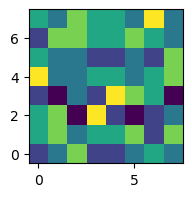

In [109]:
# recall that V is the straight line rotation operator
W = WignerMatrix(Proj(V(x^3)[:,3]), kernel=Wootters3).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

Let's find out how many vectors from the straight line MUBs are *not* present (modulo phase) in the $(2,3,4)$ MUBs.

In [96]:
for i, b in enumerate(mubs306):
    if b in mubs234:
        print('MUB {} of 306 is completely in 234'.format(i))

MUB 0 of 306 is completely in 234


In [97]:
set_diff = []
for b1 in mubs306:
    for i in range(2^N):
        v1 = b1[:,i]
        set_diff.append(v1)
        
        for b2 in mubs234:
            for j in range(2^N):
                v2 = b2[:,j]
                if v1 == v2 or v1 == I * v2 or v1 == (-I) * v2 or v1 == (-1) * v2:
                    set_diff.pop(-1)
                    break
            else:
                continue
            break

In [98]:
len(set_diff)

64

In [ ]:
W = WignerMatrix(Proj(set_diff[36]), kernel=Wootters2).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

No universality! What about for stabilizer states.

In [ ]:
W = WignerMatrix(Proj(mubs306[5][:,0]), kernel=Wootters2).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

In [ ]:
W

No luck! What about the other way around? Use the $(3,0,6)$ kernel and see what Wigner function we get for the $(2,3,4)$ vectors.

In [ ]:
W = WignerMatrix(Proj(mubs234[2][:,5]), kernel=Wootters).apply_map(lambda t: float(t))
plt.imshow(W.transpose(), origin='lower')

All of the MUBs from the $(2,3,4)$ sets have non-negative Wigner functions under the $(3,0,6)$ kernel. What makes this kernel special? And how does it affect Dr. Sainz notion of universality?

In [ ]:
def abs_inp(u, v):
    u = vector(u)
    v = vector(v)
    return abs(u.conjugate() * v)^2

In [ ]:
import numpy as np

In [ ]:
mubs306n = [np.array(m, dtype='complex128') for m in mubs306]
mubs234n = [np.array(m, dtype='complex128') for m in mubs234]

In [ ]:
plt.imshow(np.abs(mubs306n[2].conj().T @ mubs234n[6])**2)
plt.colorbar()